- `Acesso aos dados`: [MCD19A2.061: Terra & Aqua MAIAC Land Aerosol Optical Depth Daily 1km ](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD19A2_GRANULES)
- `Período dos dados`: 2000-02-24T00:00:00Z–2024-10-24T23:55:00Z
- `Resolução espacial`: 1000 metros
- `Resolução temporal`: diária
- `Variável utilizada`: Aerosol optical depth over land retrieved in the MODIS Green band (0.55 μm)
- `Código realizado por`: Enrique V. Mattos - 20/05/2024

# **1° Passo:** Instalando as bibliotecas

In [ ]:
# Instalando matplotlib, proplot e numpy
!pip install -q matplotlib==3.4.3
!pip install -q proplot==0.9.7
!pip install -q numpy==1.24.3

# Instalando salem
!pip install -q salem==0.3.9

# Instalando Xarray e suas dependências: https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
!pip install -q xarray dask netCDF4 bottleneck

# Instalando rasterio, pyproj e geopandas
!pip install -q rasterio pyproj geopandas

# Instalando cartopy
!pip uninstall shapely --yes
!pip install -q shapely cartopy==0.21.1 --no-binary shapely --no-binary cartopy

- Chegando aqui, será necessário fazer a `Reinicialização do Ambiente de Execução`. Para isto, você deverá acessar `Ambiente de execução`, localizado na barra de ferramentas e clicar em `Reiniciar Sessão`. Como indicado na imagem abaixo.

- Em seguida você deverá rodar novamente a célula anterior de instalações, de forma que as bibliotecas sejam instaladas novamente.

- Isso é necessário tanto para poder usar sem problemas o `Proplot` na nossa sessão do Colab. Então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual.

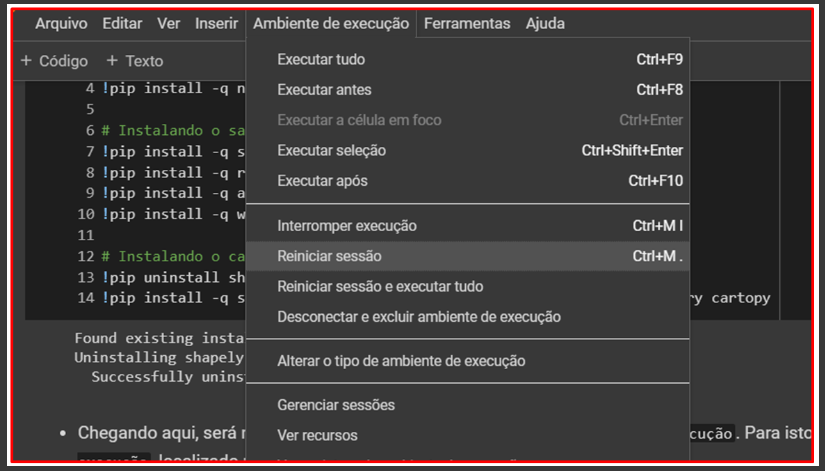

# **2° Passo:** Importando bibliotecas

In [ ]:
import numpy as np
import proplot as pplt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from zipfile import ZipFile
import salem
from datetime import datetime
import glob
import xarray as xr
import os
import cartopy.crs as ccrs
from datetime import datetime, timedelta

# vamos ignorar vários avisos
import warnings
warnings.filterwarnings('ignore')

# **3° Passo:** Monta drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/2-PESQUISA/artigo_queimadas_2024/'

# **4° Passo:** Carrega shapefile

In [ ]:
# url dos shapefiles
url = 'https://github.com/evmpython/shapefile/raw/main/'

# leitura do shapefile com a biblioteca SALEM
#itajuba = salem.read_shapefile(f'{url}itajuba/itajuba.shp')
#mg = salem.read_shapefile(f'{url}estado_MG/MG_UF_2019.shp')
shp_brasil = salem.read_shapefile(f'{url}/brasil/BRAZIL.shp')
shp_sp = salem.read_shapefile(f'{url}/UFs/SP/SP_UF_2019.shp')

# limites do estado de MG
lonmin, lonmax, latmin, latmax = -52., -39., -23., -14.

# Limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

shp_brasil

# **PARTE 1):** Inicializando o Google Earth Engine

## 1) Preparando ambiente

In [ ]:
# instalando eemont e wxee
!pip install -q eemont wxee

# importando GEE e geemap
import ee, geemap, eemont, wxee

# inicializando GEE
geemap.ee_initialize(project='ee-enrique')

## 2) Mapa no GEE

In [ ]:
%%time
#========================================================================================================================#
#                                          FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
brasil = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
#estado_mg = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Minas Gerais'))
#municipio_itajuba = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Itajuba'))

#========================================================================================================================#
#                                            CARREGA OS DADOS
#========================================================================================================================#
#('2024-08-01', '2024-09-01')

# carrega os dados. Aerosol optical depth over land retrieved in the MODIS Green band (0.55 μm).
modis_AOD_550nm = ee.ImageCollection('MODIS/061/MCD19A2_GRANULES') \
                    .filterDate('2023-01-01', '2024-01-01') \
                    .select('Optical_Depth_055') \
                    .filterBounds(brasil)

# aplica fator de escala
modis_AOD_550nm = modis_AOD_550nm.map( lambda img: img.multiply(0.001).copyProperties(img, ['system:time_start']) )

"""
# função que aolica o fator de escala
def scale(image):
    return image.multiply(0.001)\
                .copyProperties(image, ['system:time_start'])\
                .set('date', image.date().format('YYYY-MM-dd'))

# carrega os dados. Aerosol optical depth over land retrieved in the MODIS Green band (0.55 μm).
modis_AOD_550nm = ee.ImageCollection('MODIS/061/MCD19A2_GRANULES') \
                    .filter(ee.Filter.date('2024-08-01', '2024-09-01')) \
                    .select('Optical_Depth_055') \
                    .filterBounds(brasil) \
                    .map(scale)
"""

#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# cria a moldura do mapa
Map = geemap.Map()

# centraliza o mapa na região
Map.centerObject(brasil)

# parâmetros de visualização
vis = {'min': 0, 'max': 1, 'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}

# plota mapa
Map.addLayer(modis_AOD_550nm.max().clip(brasil), vis, 'Mapa de AOD 550nm')

# contorno da região
style1 = {'color': 'red', 'fillColor': '00000000'}
Map.addLayer(brasil.style(**style1), {}, 'Brasil')

# barra de cores
Map.add_colorbar_branca(colors=vis['palette'], vmin=vis['min'], vmax=vis['max'], layer_name='AOD 550nm')

# exibe na tela
Map

In [ ]:
%%time
# mostra os dados
modis_AOD_550nm

In [ ]:
%%time
# transforma a data para o formato "ano-mes-dia hora:minuto" e extrai os valores
modis_AOD_550nm_2 = modis_AOD_550nm.map(lambda img: img.set( {"DATE": ee.Date(img.get("system:time_start")).format("YYYY-MM-dd hh:mm")}))

# agrega as informações
agrega = (modis_AOD_550nm_2.aggregate_array("DATE").getInfo())

# mostra na tela
datas = pd.DataFrame(agrega)
datas

In [ ]:
datas.head(25)

In [ ]:
datas.tail(8)

# **PARTE 2):** Análise por ano de 2019 à 2024

## Produz arquivo netcdf

In [ ]:
"""
%%time
#========================================================================================================================#
#                                          FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
brasil = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
#estado_mg = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Minas Gerais'))
#municipio_itajuba = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Itajuba'))

#========================================================================================================================#
#                                           DEFINE A DATA INICIAL E FINAL
#========================================================================================================================#
# data desejada
anoi, mesi, diai = 2019, 1, 1
anof, mesf, diaf = 2025, 1, 1

#========================================================================================================================#
#                                               CARREGA OS DADOS
#========================================================================================================================#
# ajusta a data final. Soma 1 dia na data final
#datetime = datetime.strptime(f'{str(anof)}-{str(mesf).zfill(2)}-{str(diaf).zfill(2)}', '%Y-%m-%d')
#data_final = str(datetime + timedelta(days=1))[0:10] # 2024-04-01

# carrega os dados. Período entre "2019-01-01" à "2025-01-01"
modis_AOD_550nm = ee.ImageCollection('MODIS/061/MCD19A2_GRANULES') \
                    .filter(ee.Filter.date(f'{anoi}-{mesi}-{diai}', f'{anof}-{mesf}-{diaf}')) \
                    .select('Optical_Depth_055') \
                    .filterBounds(brasil)

# aplica fator de escala
modis_AOD_550nm = modis_AOD_550nm.map( lambda img: img.multiply(0.001).copyProperties(img, ['system:time_start']) )


# transforma a data inicial e final para datetime
from datetime import datetime
date_in = datetime(anoi, mesi, diai)
date_ini = date_in.strftime('%Y%m%d')

date_en = datetime(anof, mesf, diaf)
date_end = date_en.strftime('%Y%m%d')

#========================================================================================================================#
#                                          PRODUZ ARQUIVO NETCDF POR ANO
#========================================================================================================================#
# Loop entre os meses
for file in pd.date_range(date_ini, date_end, freq='1Y'):

    print('#-------------------------------------------#')
    print('.... PROCESSANDO', file)
    print('#-------------------------------------------#')

    # extrai ano e mês
    ano = file.strftime('%Y')
    mes = file.strftime('%m')

    # monta data no formato "2024-03-31"
    date = f"{ano}-{mes}-{file.strftime('%d')}"

    # extrai o range por intervalo de mês. Exemplo: "DateRange [2024-03-01 00:00:00, 2024-04-01 00:00:00]""
    range = ee.Date(date).getRange('year')

     # calcula a média mensal
    modis_AOD_550nm_ano = modis_AOD_550nm.filter(ee.Filter.date(range))

modis_AOD_550nm
"""

In [ ]:
%%time
#========================================================================================================================#
#                                          FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
brasil = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
#estado_mg = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Minas Gerais'))
#municipio_itajuba = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Itajuba'))

#========================================================================================================================#
#                                           DEFINE A DATA INICIAL E FINAL
#========================================================================================================================#
# data desejada
anoi, mesi, diai = 2019, 1, 1
anof, mesf, diaf = 2025, 1, 1

#========================================================================================================================#
#                                               CARREGA OS DADOS
#========================================================================================================================#
# ajusta a data final. Soma 1 dia na data final
#datetime = datetime.strptime(f'{str(anof)}-{str(mesf).zfill(2)}-{str(diaf).zfill(2)}', '%Y-%m-%d')
#data_final = str(datetime + timedelta(days=1))[0:10] # 2024-04-01

# carrega os dados. Período entre "2019-01-01" à "2025-01-01"
modis_AOD_550nm = ee.ImageCollection('MODIS/061/MCD19A2_GRANULES') \
                    .filter(ee.Filter.date(f'{anoi}-{mesi}-{diai}', f'{anof}-{mesf}-{diaf}')) \
                    .select('Optical_Depth_055') \
                    .filterBounds(brasil)

# aplica fator de escala
modis_AOD_550nm = modis_AOD_550nm.map( lambda img: img.multiply(0.001).copyProperties(img, ['system:time_start']) )


# transforma a data inicial e final para datetime
from datetime import datetime
date_in = datetime(anoi, mesi, diai)
date_ini = date_in.strftime('%Y%m%d')

date_en = datetime(anof, mesf, diaf)
date_end = date_en.strftime('%Y%m%d')

#========================================================================================================================#
#                                          PRODUZ ARQUIVO NETCDF POR ANO
#========================================================================================================================#
# Loop entre os meses
for file in pd.date_range(date_ini, date_end, freq='1Y'):

    print('#-------------------------------------------#')
    print('.... PROCESSANDO', file)
    print('#-------------------------------------------#')

    # extrai ano e mês
    ano = file.strftime('%Y')
    mes = file.strftime('%m')

    # monta data no formato "2024-03-31"
    date = f"{ano}-{mes}-{file.strftime('%d')}"

    # extrai o range por intervalo de ano. Exemplo: .Date('2019-12-31').getRange('year') --> "2019-01-01" à "2020-01-01"
    range = ee.Date(date).getRange('year')

    # calcula a média mensal
    modis_AOD_550nm_ano = modis_AOD_550nm.filter(ee.Filter.date(range)).max().clip(brasil).set('system:time_start', 0)

    # convertendo para xarray.Dataset
    ds_modis_AOD_550nm_ano = modis_AOD_550nm_ano.clip(brasil).wx.to_xarray(region=brasil.geometry(), scale=20_000)

    # salva arquivo netcdf
    ds_modis_AOD_550nm_ano.to_netcdf(f'{dir}output/02_AOD_550nm/modis_AOD_550nm_anual_20km_{ano}.nc')

In [ ]:
# exemplo do arquivo netcdf gerado
ds_modis_AOD_550nm_ano

## Plota figura - `BRASIL`

In [ ]:
 ds = xr.open_dataset(f'{dir}output/01_monoxido_carbono/S5P_co_anual_20km_2023.nc')
 ds

In [ ]:
%%time
# import bibliotecas
import proplot as pplt
import cartopy.io.shapereader as shpreader
import cartopy, cartopy.crs as ccrs
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

# Limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# cria a moldura da figura
fig, ax = pplt.subplots(figsize=(10, 8.5),
                        nrows=2, ncols=3,
                        tight=True,
                        proj='pcarree',
                        sharex=True, sharey=True)

# formatação dos eixos
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          suptitle=f'Annual Carbon Monoxide for Brazil',
          small='20px', large='25px',
          linewidth=0, grid=False)

# loop dos anos
for i, ano in enumerate(np.arange(2019, 2025)):

  # exibe na tela o ano que esta sendo processado
  print(f'Processando o ano: .... {i} {ano}')

  # leitura do arquivo netcdf
  ds = xr.open_dataset(f'{dir}output/01_monoxido_carbono/S5P_co_anual_20km_{ano}.nc')

  # plota figura. Opções de palletes: https://proplot.readthedocs.io/en/latest/colormaps.html
  map1 = ax[i].contourf(ds['x'],
                        ds['y'],
                        ds['CO_column_number_density'][0, :, :].salem.roi(shape=shp_brasil),
                        cmap='lajolla',
                        vmin=50, vmax=350,
                        levels=pplt.arange(50, 350, 10),
                        extend='max')

  # plota titulo de cada figura
  ax[i].format(title=ano, labels = False, titleloc='c', titlecolor='grey', titleweight='bold')

  # plota contornos. Tempo= 9min 10s
  #estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
  #estados_brasil.plot(edgecolor='black', facecolor='none', linewidth=0.5, alpha=1, ax=ax[i])

  # ou. Tempo=2min 43s
  shapefile = list(shpreader.Reader('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp').geometries())
  ax[i].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=0.3)

# plota barra de cores da figura
fig.colorbar(map1,
             loc='b',
             label='Dobson Unit (DU)\nSource: Sentinel-5P/Pixel: 20km',
             ticks=50,
             ticklabelsize=13,
             labelsize=13,
             length=0.85,
             width=0.25,
             space=0.0)

# salva figura
fig.savefig(f'{dir}output/02_AOD_550nm/Fig_1_MODIS_AOD_550nm_anual_Brasil.jpg', transparent=True, dpi=300, bbox_inches="tight")

## Plota figura - `SÃO PAULO`

In [ ]:
%%time
# import bibliotecas
import proplot as pplt
import cartopy.io.shapereader as shpreader
import cartopy, cartopy.crs as ccrs
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

# Limites de SP
lonmin, lonmax, latmin, latmax = -53.3, -43.9, -25.4, -19.7

# cria a moldura da figura
fig, ax = pplt.subplots(figsize=(10, 6),
                        nrows=2, ncols=3,
                        tight=True,
                        proj='pcarree',
                        sharex=True, sharey=True)

# formatação dos eixos
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          suptitle=f'Annual Carbon Monoxide for Sao Paulo State',
          small='20px', large='25px',
          linewidth=0, grid=False)

# loop dos anos
for i, ano in enumerate(np.arange(2019, 2025)):

  # exibe na tela o ano que esta sendo processado
  print(f'Processando o ano: .... {ano}')

  # leitura do arquivo netcdf
  ds = xr.open_dataset(f'{dir}output/01_monoxido_carbono/S5P_co_anual_20km_{ano}.nc')

  # plota figura. Opções de palletes: https://proplot.readthedocs.io/en/latest/colormaps.html
  map1 = ax[i].contourf(ds['x'],
                        ds['y'],
                        ds['CO_column_number_density'][0, :, :].salem.roi(shape=shp_sp),
                        cmap='lajolla',
                        vmin=50, vmax=350,
                        levels=pplt.arange(50, 350, 10),
                        extend='max')

  # plota titulo de cada figura
  ax[i].format(title=ano, labels = False, titleloc='c', titlecolor='grey', titleweight='bold')

  # plota contornos. Tempo= 9min 10s
  #estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/UFs/SP/SP_UF_2019.shp')
  #estados_brasil.plot(edgecolor='black', facecolor='none', linewidth=0.5, alpha=1, ax=ax[i])

  # ou. Tempo=2min 43s
  shapefile = list(shpreader.Reader('https://github.com/evmpython/shapefile/raw/main/UFs/SP/SP_UF_2019.shp').geometries())
  ax[i].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=0.3)

# plota barra de cores da figura
fig.colorbar(map1,
             loc='b',
             label='Dobson Unit (DU)\nSource: Sentinel-5P/Pixel: 20km',
             ticks=50,
             ticklabelsize=13,
             labelsize=13,
             length=0.85,
             width=0.25,
             space=0.0)

# salva figura
fig.savefig(f'{dir}output/02_AOD_550nm/Fig_2_MODIS_AOD_550nm_anual_SP.jpg', transparent=True, dpi=300, bbox_inches="tight")

# **PARTE 3):** Análise por mês do ano de 2024

## Produz arquivo netcdf
- Demora  21min 35s para processar 10 meses de dados

In [ ]:
%%time
#========================================================================================================================#
#                                          FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
brasil = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
#estado_mg = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Minas Gerais'))
#municipio_itajuba = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Itajuba'))

#========================================================================================================================#
#                                           DEFINE A DATA INICIAL E FINAL
#========================================================================================================================#
# data desejada
anoi, mesi, diai = 2024, 1, 1
anof, mesf, diaf = 2024, 11, 1
#========================================================================================================================#
#                                               CARREGA OS DADOS
#========================================================================================================================#
# ajusta a data final. Soma 1 dia na data final
datetime = datetime.strptime(f'{str(anof)}-{str(mesf).zfill(2)}-{str(diaf).zfill(2)}', '%Y-%m-%d')
data_final = str(datetime + timedelta(days=1))[0:10] # 2024-04-01

# carrega os dados. Período entre "2019-01-01" à "2025-01-01"
S5P_co = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CO') \
           .filter(ee.Filter.date(f'{anoi}-{mesi}-{diai}', data_final)) \
           .select('CO_column_number_density') \
           .filterBounds(brasil)

# transforma a data inicial e final para datetime
from datetime import datetime
date_in = datetime(anoi, mesi, diai)
date_ini = date_in.strftime('%Y%m%d')

date_en = datetime(anof, mesf, diaf)
date_end = date_en.strftime('%Y%m%d')

#========================================================================================================================#
#                                          PRODUZ ARQUIVO NETCDF POR ANO
#========================================================================================================================#
# Loop entre os meses
for file in pd.date_range(date_ini, date_end, freq='1M'):

    print('#-------------------------------------------#')
    print('.... PROCESSANDO', file)
    print('#-------------------------------------------#')

    # extrai ano e mês
    ano = file.strftime('%Y')
    mes = file.strftime('%m')

    # monta data no formato "2024-03-31"
    date = f"{ano}-{mes}-{file.strftime('%d')}"

    # extrai o range por intervalo de ano. Exemplo: .Date('2019-12-31').getRange('year') --> "2019-01-01" à "2020-01-01"
    range = ee.Date(date).getRange('month')

    # calcula a média mensal
    S5P_co_mes = S5P_co.filter(ee.Filter.date(range)).max().clip(brasil).multiply(2241.15).set('system:time_start', 0)

    # convertendo para xarray.Dataset
    ds_S5P_co_mes = S5P_co_mes.clip(brasil).wx.to_xarray(region=brasil.geometry(), scale=20_000)

    # salva arquivo netcdf
    ds_S5P_co_mes.to_netcdf(f'{dir}output/01_monoxido_carbono/S5P_co_mensal_20km_{ano}-{mes}.nc')

In [ ]:
S5P_co.filter(ee.Filter.date(range))

## Plota figura - `BRASIL`

In [ ]:
%%time
# import bibliotecas
import proplot as pplt
import cartopy.io.shapereader as shpreader
import cartopy, cartopy.crs as ccrs
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# meses
meses = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# cria a moldura da figura
fig, ax = pplt.subplots(figsize=(10, 12),
                        nrows=4, ncols=3,
                        tight=True,
                        proj='pcarree',
                        sharex=True, sharey=True)

# formatação dos eixos
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          suptitle=f'Monthly Carbon Monoxide in Brazil for 2024',
          small='20px', large='25px',
          linewidth=0, grid=False)

# loop dos meses de 2024
i=0
for data in pd.date_range('20240101', '20241031', freq='1M'):

    # estrai ano e mês
    ano = data.strftime('%Y')
    mes = data.strftime('%m')

    print('Processando ===>>>', f'{i}-{ano}-{mes}')

    # leitura do arquivo netcdf
    ds = xr.open_dataset(f'{dir}output/01_monoxido_carbono/S5P_co_mensal_20km_{ano}-{mes}.nc')

    # plota figura
    map1 = ax[i].contourf(ds['x'],
                          ds['y'],
                          ds['CO_column_number_density'][0, :, :].salem.roi(shape=shp_brasil),
                          cmap='lajolla',
                          vmin=50, vmax=350,
                          levels=pplt.arange(50, 350, 10),
                          extend='max')

    # plota titulo de cada figura
    mesint = int(mes)
    ax[i].format(title=f'{meses[mesint-1]}', labels = False, titleloc='c', titlecolor='grey')

    # plota contornos. Tempo= 9min 10s
    #estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
    #estados_brasil.plot(edgecolor='black', facecolor='none', linewidth=0.5, alpha=1, ax=ax[i])

    # ou. Tempo=2min 43s
    shapefile = list(shpreader.Reader('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp').geometries())
    ax[i].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=0.3)

    i+=1

# plota barra de cores da figura
fig.colorbar(map1,
             loc='b',
             label='Dobson Unit (DU)\nSource: Sentinel-5P/Pixel: 20km',
             ticks=50,
             ticklabelsize=13,
             labelsize=13,
             length=0.85,
             width=0.25,
             space=-12,
             cols=(2,3))

# salva figura
fig.savefig(f'{dir}output/02_AOD_550nm/Fig_3_MODIS_AOD_550nm_mensal_2024_Brasil.jpg', transparent=True, dpi=300, bbox_inches="tight")

## Plota figura - `SÃO PAULO`

In [ ]:
%%time
# import bibliotecas
import proplot as pplt
import cartopy.io.shapereader as shpreader
import cartopy, cartopy.crs as ccrs
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Limites de SP
lonmin, lonmax, latmin, latmax = -53.3, -43.9, -25.4, -19.7

# meses
meses = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# cria a moldura da figura
fig, ax = pplt.subplots(figsize=(10,12),
                        nrows=4, ncols=3,
                        tight=True,
                        proj='pcarree',
                        sharex=True, sharey=True)

# formatação dos eixos
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          suptitle=f'Monthly Carbon Monoxide in São Paulo State for 2024',
          small='20px', large='25px',
          linewidth=0, grid=False)

# loop dos meses de 2024
i=0
for data in pd.date_range('20240101', '20241031', freq='1M'):

    # estrai ano e mês
    ano = data.strftime('%Y')
    mes = data.strftime('%m')

    print('Processando ===>>>', f'{i}-{ano}-{mes}')

    # leitura do arquivo netcdf
    ds = xr.open_dataset(f'{dir}output/01_monoxido_carbono/S5P_co_mensal_20km_{ano}-{mes}.nc')

    # plota figura
    map1 = ax[i].contourf(ds['x'],
                          ds['y'],
                          ds['CO_column_number_density'][0, :, :].salem.roi(shape=shp_sp),
                          cmap='lajolla',
                          vmin=50, vmax=350,
                          levels=pplt.arange(50, 350, 10),
                          extend='max')

    # plota titulo de cada figura
    mesint = int(mes)
    ax[i].format(title=f'{meses[mesint-1]}', labels = False, titleloc='c', titlecolor='grey')

    # plota contornos. Tempo= 9min 10s
    #estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/UFs/SP/SP_UF_2019.shp')
    #estados_brasil.plot(edgecolor='black', facecolor='none', linewidth=0.5, alpha=1, ax=ax[i])

    # ou. Tempo=2min 43s
    shapefile = list(shpreader.Reader('https://github.com/evmpython/shapefile/raw/main/UFs/SP/SP_UF_2019.shp').geometries())
    ax[i].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=0.3)

    i+=1

# plota barra de cores da figura
fig.colorbar(map1,
             loc='b',
             label='Dobson Unit (DU)\nSource: Sentinel-5P/Pixel: 20km',
             ticks=50,
             ticklabelsize=13,
             labelsize=13,
             length=0.85,
             width=0.25,
             space=-12,
             cols=(2,3))

# salva figura
fig.savefig(f'{dir}output/02_AOD_550nm/Fig_4_MODIS_AOD_550nm_mensal_2024_sp.jpg', transparent=True, dpi=300, bbox_inches="tight")